# Parameter identification interface
### User-interface to perform parameter identification of bioscrape/SBML models

* Simple functions to import models/data 
* Use the fast deterministic and stochastic simulators available within bioscrape
* (Optionally) Specify paramter priors, desired likelihood/cost functions 
* Create your own likelihood functions interface

## Loglikelihood Functions
Bioscrape comes with a number of built in log-likelihood functions for deterministic or stochastic parameter inference. These functions are detailed in the following notebook. First, a simple model is made to test the functions:

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

A set of N trajectories is then generated from this model, from either the same or different initial conditions, across the same or different time-windows. Gaussian noise is then added to all the samples.

In [3]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt

# Import bioscrape XML / bioscrape model object M / SBML file
# M  = bs.types.read_model_from_sbml(filename)
# M = Model('models/pid_model.xml')

# Or...Create a Model using the bioscrape API
species = ['X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), ([], ['X'], 'massaction', {'k':'k1'})]
k1 = 10.0
d1 = .2
params = [('k1', k1), ('d1', d1)]
initial_condition = {'X':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

# Import data from CSV
# data = import_timeseries('test_data.csv', time_column = 2, value_column = 4, properties = {3 : 51})

M.py_initialize()

N = 10 #Number of trajectories
nT = 50 #number of timepoints
noise_std = 0.2 #Standard deviation of the guassian noise added onto the measurements

MultipleTimepoints = True #Different timepoints for each trajectory?
timepoint_list = []
# timepoints = np.linspace(np.random.randint(0, 10), np.random.randint(10, 100), nT)
timepoints = np.linspace(0, 100, nT)
#Generate Trajectories
R = [] #Results as Pandas Dataframes
data = [] #Results will become a numpy array
MultipleInitialConditions = True #Different initial conditions for each trajectory?

X0_list = [] #multiple initial conditions will be saved for inference
for n in range(N):
    if MultipleInitialConditions:
        initial_condition = {'X': np.random.randint(0, 100)}
        X0_list.append(initial_condition)
        
    if MultipleTimepoints:
        timepoints = np.linspace(np.random.randint(0, 10, 1), np.random.randint(10, 100, 1), num = 50).flatten()
        timepoint_list.append(timepoints)
    
    M.set_species(initial_condition)
    r = py_simulate_model(timepoints, Model = M, stochastic = True)
    R.append(r)
    noisy_data = r['X'].to_numpy() + np.random.normal(loc = 0, scale = noise_std, size = nT)
    data.append(noisy_data)

M_original = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)
# M_original.write_bioscrape_xml('toy_model.xml')


### To run the MCMC algorithm to identify parameters from the data, the following code can be used.

In [5]:
# Run parameter identification procedure using Python emcee -
from bioscrape.pid_interfaces import *
from bioscrape.emcee_interface import *

pid = initialize_mcmc()
pid.exp_data = np.array(data)
pid.M = M
pid.prior = {'k1' : ['uniform', 1e-2, 1e4],'d1' : ['uniform', 1e-3, 1e3]}
pid.params_to_estimate = {'k1':10, 'd1':0.2}
pid.type = 'deterministic'
pid.timepoints = timepoint_list
pid.initial_conditions = X0_list
pid.nsamples = 500
pid.nsteps = 200
pid.nwalkers = 200
fitted_model, params = pid.run_mcmc(plot_show = True, progress = False)

Sample log-like: 3554.650236814711
Sample log-like: 3555.210528555509
Sample log-like: 3554.5589244584767
Sample log-like: 3553.888668572453
Sample log-like: 3554.4230290002415
Sample log-like: 3554.286401710743
Sample log-like: 3554.4649645211134
Sample log-like: 3554.7408724254715
Sample log-like: 3555.539418611863
Sample log-like: 3554.609050068592
Sample log-like: 3554.912064353745
Sample log-like: 3554.8394701589377
Sample log-like: 3555.3744627470096
Sample log-like: 3553.372458669302
Sample log-like: 3555.1902510326254
Sample log-like: 3555.0133161502763
Sample log-like: 3555.289709413083
Sample log-like: 3555.013376658922
Sample log-like: 3554.7011579698633
Sample log-like: 3552.4945505850283
Sample log-like: 3554.9842908638307
Sample log-like: 3552.7430797255215
Sample log-like: 3554.962236899007
Sample log-like: 3553.470785232147
Sample log-like: 3554.030456438444
Sample log-like: 3554.508274856488
Sample log-like: 3554.88327130688
Sample log-like: 3554.4097913159494
Sample l

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Sample log-like: 3555.1740220353813
Sample log-like: 3554.4831095423338
0.0 percent complete
0.5 percent complete
emcee: Exception while calling your likelihood function:
  params: [3.37878247 0.19775583]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\bioscrape\emcee_interface.py", line 99, in cost_function
    return pid_interface.get_likelihood_function(log_params, exp_data, timepoints, measurements, initial_conditions)
  File "c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\bioscrape\pid_interfaces.py", line 134, in get_likelihood_function
    dataDet = BulkData(np.array(timepoints), data, measurements, N)
KeyboardInterrupt


KeyboardInterrupt: 

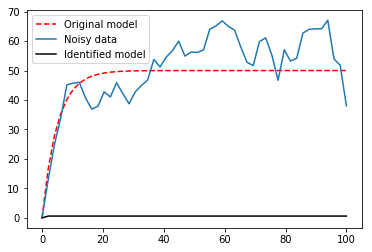

In [14]:
sim_x = py_simulate_model(timepoints, Model = M_original, stochastic = False)
sim_x_inf = py_simulate_model(timepoints, Model = fitted_model, stochastic = False)
plt.plot(timepoints, sim_x['X'], 'r--', label = 'Original model')
plt.plot(timepoints, noisy_data, label = 'Noisy data')
plt.plot(timepoints, sim_x_inf['X'], 'k', label = 'Identified model')

plt.legend()

In [7]:
fitted_model.get_parameter_values()

array([1.57056605e-04, 5.24060327e+00])

In [ ]:
import pandas as pd
# Write noisy data to csv
# df = pd.concat(R)
file_name = 'test_data.csv'
R[0].to_csv(file_name, sep='\t', header = True)